In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import datetime
import numpy as np
import seaborn as sns
import re
import json
import pandas as pd
import math
import ast
import os
from collections import defaultdict
import sys
sys.path.append('..')
from utilities import logger
from utilities import configuration
from utilities import health_data

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier

from scipy import stats


In [18]:
config = configuration.get_config()
for key in config:
    print(f'{key:40} (type: {type(config[key])})')


logging = logger.init_logger(config['system_log'])
logging.debug('Logger has started ont notebook 09 Random sample of instances.ipynb ...')

system_log                               (type: <class 'str'>)
json_file                                (type: <class 'str'>)
train_val_json                           (type: <class 'str'>)
heldout_json                             (type: <class 'str'>)
unused_after_heldout_json                (type: <class 'str'>)
unified_merged_file_cz                   (type: <class 'str'>)
unified_merged_file_noncz                (type: <class 'str'>)
unified_merged_file                      (type: <class 'str'>)
data_path                                (type: <class 'str'>)
cz_files                                 (type: <class 'list'>)
noncz_files                              (type: <class 'list'>)
2023-11-16 17:41:23,693 - root - DEBUG - Logger has started ont notebook 09 Random sample of instances.ipynb ...


In [19]:
f = open(config['train_val_json'])
train_val_data = json.load(f)
print(len(train_val_data))

all_admissions = []
for ix in train_val_data:
    all_admissions.append(
        health_data.Admission.from_dict_data(admit_id=int(ix), admission=train_val_data[ix])
        )
len(all_admissions)

# Dictionary organizing data by patient
patient2admissions = defaultdict(list)
for admission in all_admissions:
    code = admission.code
    patient2admissions[code].append(admission)

# Ordering patient list by discharge date (from back )
for patient_code in patient2admissions:
    admissions_list = patient2admissions[patient_code]
    admissions_list = sorted(admissions_list, key=lambda admission: admission.discharge_date, reverse=False)
    assert all([admissions_list[i].discharge_date <= admissions_list[i+1].discharge_date for i in range(len(admissions_list)-1)])
    patient2admissions[patient_code] = admissions_list

patient_count=0
valid_readmission_count=0
for patient_code in patient2admissions:
    patient_admissions = patient2admissions[patient_code]
    ix = 0 
    while ix < len(patient_admissions):
        readmission_code = patient_admissions[ix].readmission_code
        if health_data.ReadmissionCode.is_readmit(readmission_code):
            # Either is not the first admission (ix>0) or 
            # we don't have the patient previous admition (readmission close to begining of dataset) (admit-(2015-01-01))<28 days
            # assert ix>0 or (patient_admissions[ix].admit_date - datetime.datetime.fromisoformat('2015-01-01')).days<365
            if ix>0 and  patient_admissions[ix-1].is_valid_readmission(patient_admissions[ix]):
                patient_admissions[ix-1].add_readmission(patient_admissions[ix])
                valid_readmission_count+=1
        ix+=1
    patient_count+=1


print(f'Size of train_val data:   {len(all_admissions):,}')
print(f"Begining heldout:         {min([admission.discharge_date for admission in all_admissions])}")
print(f"End heldout:              {max([admission.discharge_date for admission in all_admissions])}")
print(f'Number of instances with readmissions: {valid_readmission_count} ({valid_readmission_count/len(all_admissions):.2%})')



524986
Size of train_val data:   524,986
Begining heldout:         2015-01-01 00:00:00
End heldout:              2021-10-01 00:00:00
Number of instances with readmissions: 50533 (9.63%)


## Numerical

  - age
  - cmg
  - case_weight
  - alc_days
  - acute_days


### Summarizing table

In [42]:
data = pd.Series([admission.age for admission in all_admissions], name='Age')
result = data.describe()
print(','.join(['Variable'] + list(result.index) + ['Kurtosis'] + ['Skew']+ ['Mode']))

for field in ['age', 'cmg', 'case_weight', 'alc_days','acute_days',] :
    data = pd.Series([getattr(admission,field) for admission in all_admissions], name='Age')
    result = data.describe()
    print(','.join([field]+[str(elem) for elem in result] \
                   + [str(stats.kurtosis(data[~np.isnan(data)]))] \
                    + [str(stats.skew(data[~np.isnan(data)]))] \
                        + [str(stats.mode(data))] ))

Variable,count,mean,std,min,25%,50%,75%,max,Kurtosis,Skew,Mode
age,524986.0,58.693555637674145,23.553071410066007,-1.0,46.0,64.0,76.0,110.0,0.12126813768703304,-0.8651799654770388,ModeResult(mode=0, count=26316)
cmg,524881.0,411.51968922479574,245.55904303293053,1.0,196.0,337.0,635.0,999.0,-1.2612974627183535,0.27081751350328664,ModeResult(mode=139.0, count=16221)
case_weight,524881.0,1.790838783457584,5.963467481250685,0.0,0.537,0.923,1.6178,2000.0,48923.46755265561,164.45055972516923,ModeResult(mode=1.1182, count=2184)
alc_days,524986.0,1.8289421051228032,29.925166418653113,0.0,0.0,0.0,0.0,16300.0,170148.266403125,328.09480506183144,ModeResult(mode=0, count=507129)
acute_days,524986.0,8.58813758843093,68.45847086921214,0.0,2.0,4.0,8.0,17343.0,51053.12180632098,213.53241167262578,ModeResult(mode=1, count=102449)


### Figures for Age and CMG

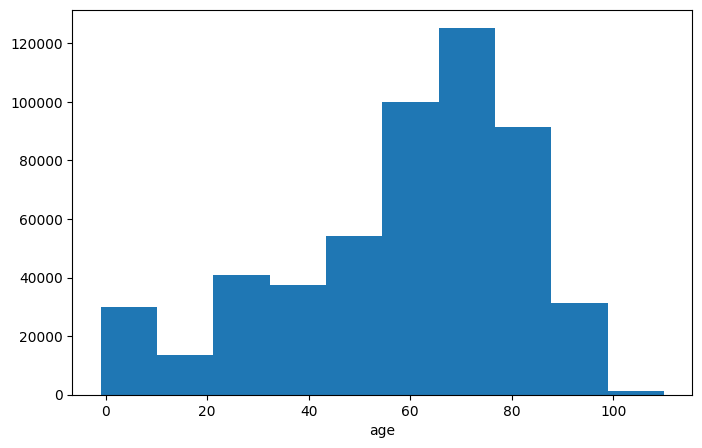

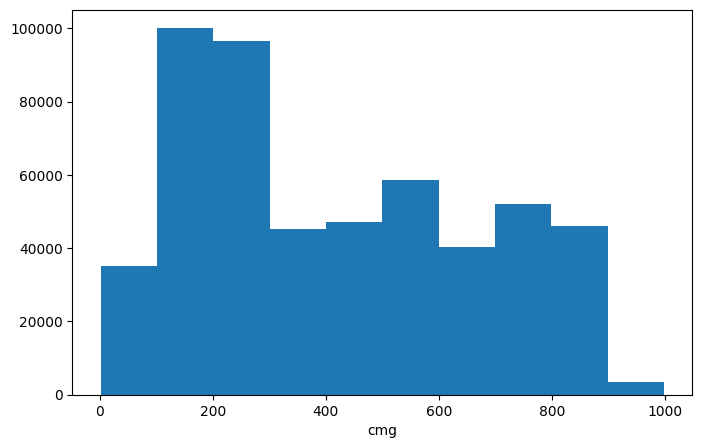

In [21]:
for field in ['age', 'cmg',]:
    data = pd.Series([getattr(admission,field) for admission in all_admissions], name='Age')
    fig, ax = plt.subplots(1,figsize=(8,5), )
    ax.hist(data, bins=10)
    ax.set_xlabel(field)

### Figure for ALC Days (removing 3stds and zeros)

Removed for ALC Days = 2989


Text(0.5, 0, 'ALC Days')

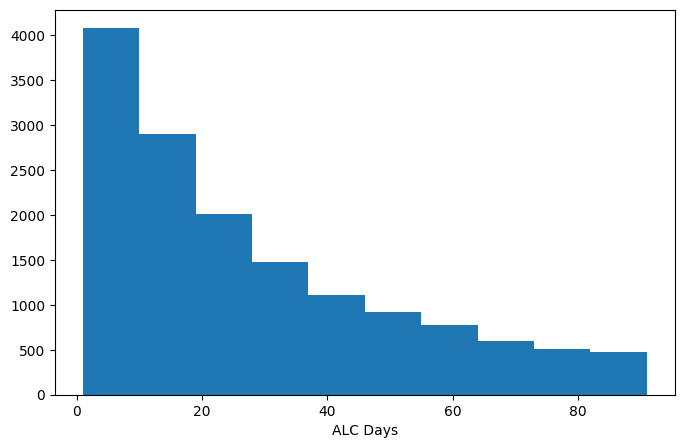

In [46]:
data = np.array([getattr(admission,'alc_days') for admission in all_admissions], )
data = data[~np.isnan(data)]

std_ = np.std(data)
print(f'Removed for ALC Days = {np.sum(data>np.mean(data)+3*std_)}')

data = data[data<=np.mean(data)+3*std_]
fig, ax = plt.subplots(1,figsize=(8,5), )
ax.hist(data[data!=0])
ax.set_xlabel('ALC Days')

### Acute Days (Removing 3stds)

Removed for Acute Days = 394


Text(0.5, 0, 'Acute Days')

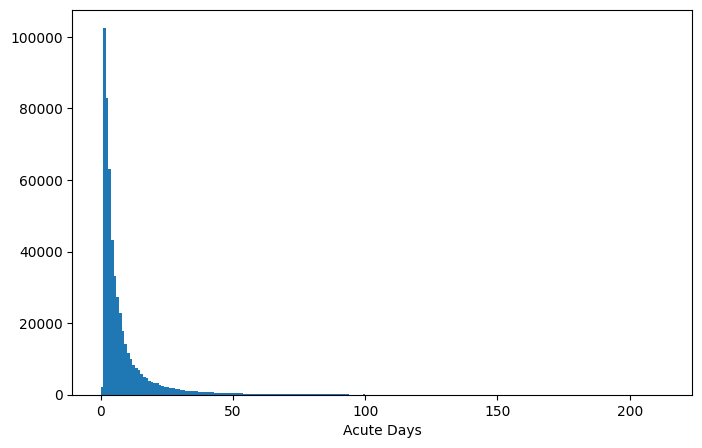

In [81]:
data = np.array([getattr(admission,'acute_days') for admission in all_admissions], )
std_ = np.std(data)
print(f'Removed for Acute Days = {np.sum(data>np.mean(data)+3*std_)}')
data = data[data<=np.mean(data)+3*std_]
fig, ax = plt.subplots(1,figsize=(8,5), )

            
ax.hist(data,bins=max(data))
ax.set_xlabel('Acute Days')

### CMG (Removing 3tds)

Removed for Case Weight = 3335


Text(0.5, 0, 'Case Weight')

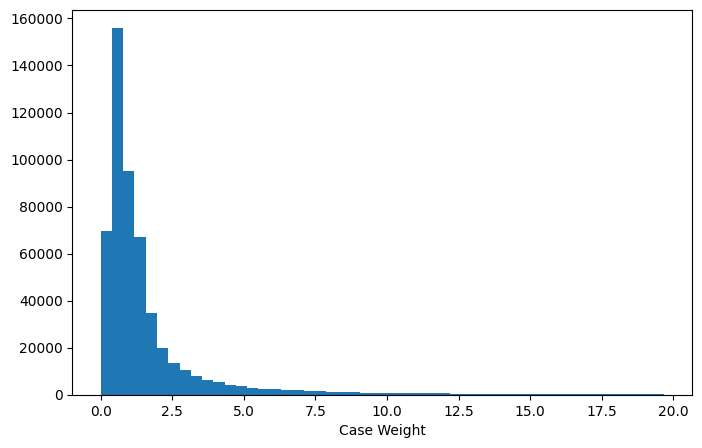

In [80]:
data = np.array([getattr(admission,'case_weight') for admission in all_admissions], )
data = np.array([float(elem) for elem in data if not elem is None])
data = data[~np.isnan(data)]

std_ = np.std(data)
print(f'Removed for Case Weight = {np.sum(data>np.mean(data)+3*std_)}')
data = data[data<=np.mean(data)+3*std_]
fig, ax = plt.subplots(1,figsize=(8,5), )

            
ax.hist(data,bins=50)
ax.set_xlabel('Case Weight')


## Multiple variables plots

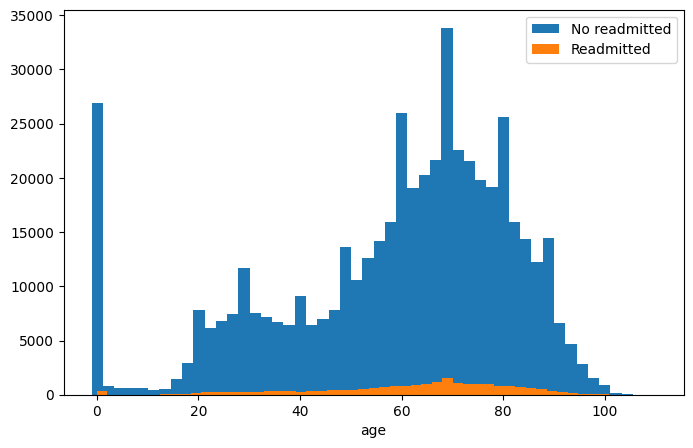

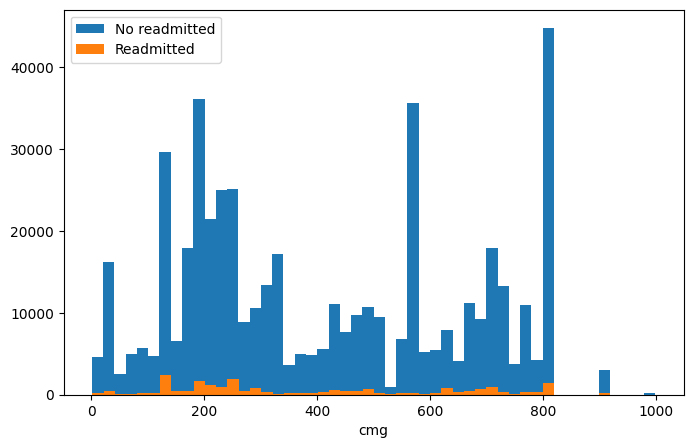

In [108]:
for field in ['age', 'cmg',]:

    data = pd.Series([getattr(admission,field) for admission in all_admissions], name='Age')
    y = health_data.Admission.get_y(all_admissions)
    fig, ax = plt.subplots(1,figsize=(8,5), )
    ax.hist(data[y==0], bins=50, label='No readmitted')
    ax.hist(data[y==1], bins=50, label='Readmitted')
    ax.set_xlabel(field)
    ax.legend()

Removed for ALC Days = 2989


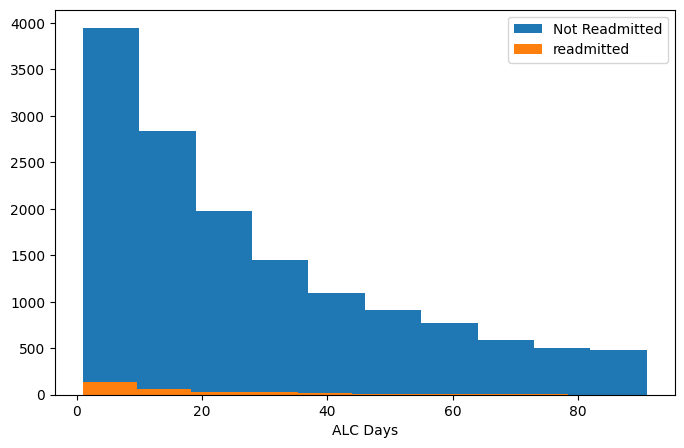

In [110]:
data = np.array([getattr(admission,'alc_days') for admission in all_admissions], )
y = health_data.Admission.get_y(all_admissions)

# Removing Nan
y = y[~np.isnan(data)]
data = data[~np.isnan(data)]

std_ = np.std(data)
print(f'Removed for ALC Days = {np.sum(data>np.mean(data)+3*std_)}')

# Removing 3stds
y = y[data<=np.mean(data)+3*std_]
data = data[data<=np.mean(data)+3*std_]

fig, ax = plt.subplots(1,figsize=(8,5), )

# Removing Zeros
y = y[data!=0]
data = data[data!=0]

ax.hist(data[y==0], label='Not Readmitted')
ax.hist(data[y==1], label='readmitted')
ax.set_xlabel('ALC Days')
ax.legend()

Removed for Acute Days = 394


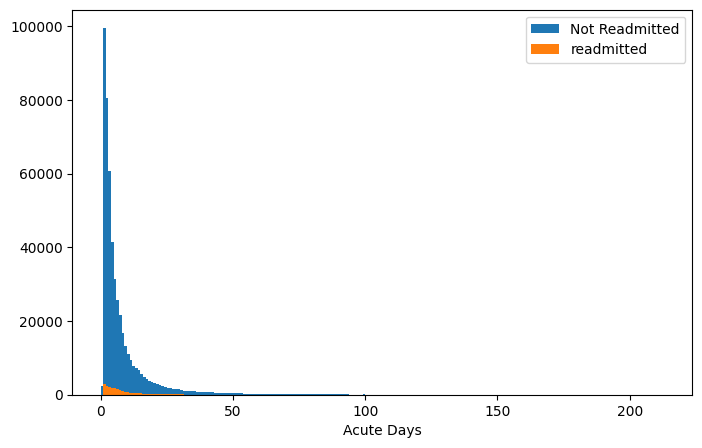

In [113]:
data = np.array([getattr(admission,'acute_days') for admission in all_admissions], )
y = health_data.Admission.get_y(all_admissions)


std_ = np.std(data)
print(f'Removed for Acute Days = {np.sum(data>np.mean(data)+3*std_)}')
y = y[data<=np.mean(data)+3*std_]
data = data[data<=np.mean(data)+3*std_]
fig, ax = plt.subplots(1,figsize=(8,5), )

            
ax.hist(data[y==0], bins=max(data), label='Not Readmitted')
ax.hist(data[y==1], bins=max(data), label='readmitted')
ax.set_xlabel('Acute Days')
ax.legend()

Removed for Case Weight = 3335


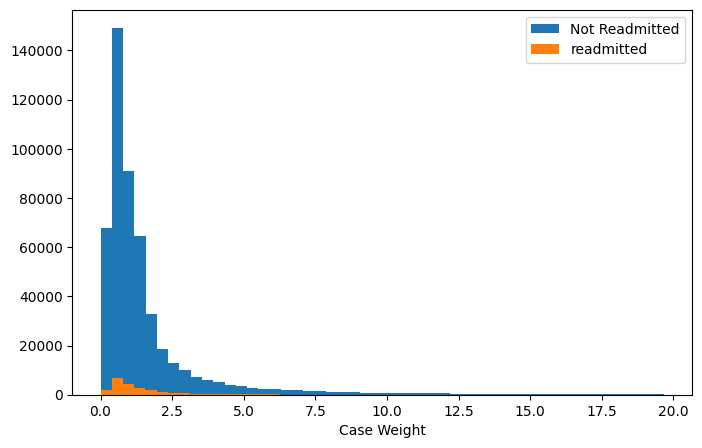

In [115]:
data = np.array([getattr(admission,'case_weight') for admission in all_admissions], )
y = health_data.Admission.get_y(all_admissions)

y = np.array([y_value for y_value,elem in zip(y, data) if not elem is None])
data = np.array([float(elem) for elem in data if not elem is None])

y = y[~np.isnan(data)]
data = data[~np.isnan(data)]

std_ = np.std(data)
print(f'Removed for Case Weight = {np.sum(data>np.mean(data)+3*std_)}')
y = y[data<=np.mean(data)+3*std_]
data = data[data<=np.mean(data)+3*std_]
fig, ax = plt.subplots(1,figsize=(8,5), )

            
ax.hist(data[y==0], bins=50, label='Not Readmitted')
ax.hist(data[y==1], bins=50, label='readmitted')
ax.set_xlabel('Case Weight')
ax.legend()


### Correlation Matrix

In [138]:
numeric_field = ['age', 'cmg', 'case_weight', 'alc_days','acute_days',] 
y = health_data.Admission.get_y(all_admissions)
df = pd.DataFrame(np.vstack([y] + [np.array([getattr(admission,field) for admission in all_admissions] ) for field in numeric_field ]).T,
                  columns=['target']+list(numeric_field)
                 )

# df = df[~df.isna()]?
df

,target,age,cmg,case_weight,alc_days,acute_days
0,0,67,285.0,1.3894,0,8
1,1,38,278.0,0.6825,0,2
2,0,62,319.0,1.8371,0,3
3,0,37,729.0,1.0085,0,1
4,0,49,321.0,1.4334,0,3
...,...,...,...,...,...,...
524981,0,74,780.0,0.5023,0,1
524982,0,61,234.0,0.4418,0,2
524983,0,73,778.0,0.4942,0,5
524984,0,68,386.0,0.9858,0,2


In [139]:
df.corr()

,target,age,cmg,case_weight,alc_days,acute_days
target,1.000000,0.029683,-0.019608,-0.004546,-0.009699,0.001239
age,0.029683,1.000000,-0.163179,0.084478,0.043867,0.023789
cmg,-0.019608,-0.163179,1.000000,0.017858,0.044955,0.039972
case_weight,-0.004546,0.084478,0.017858,1.000000,0.635643,0.739212
alc_days,-0.009699,0.043867,0.044955,0.635643,1.000000,0.046810
acute_days,0.001239,0.023789,0.039972,0.739212,0.046810,1.000000


### Working on Skeweness

Removed for Case Weight = 3335


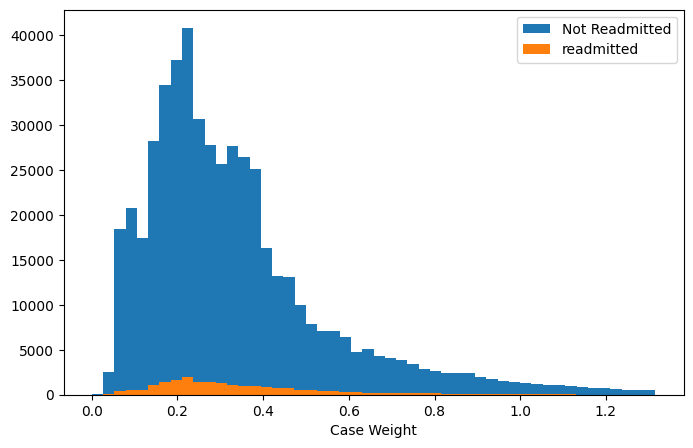

In [45]:
data = np.array([getattr(admission,'case_weight') for admission in all_admissions], )
y = health_data.Admission.get_y(all_admissions)

y = np.array([y_value for y_value,elem in zip(y, data) if not elem is None])
data = np.array([float(elem) for elem in data if not elem is None])

y = y[~np.isnan(data)]
data = data[~np.isnan(data)]

std_ = np.std(data)
print(f'Removed for Case Weight = {np.sum(data>np.mean(data)+3*std_)}')
y = y[data<=np.mean(data)+3*std_]
data = data[data<=np.mean(data)+3*std_]
fig, ax = plt.subplots(1,figsize=(8,5), )

data = np.log10(data+1)
            
ax.hist(data[y==0], bins=50, label='Not Readmitted')
ax.hist(data[y==1], bins=50, label='readmitted')
ax.legend()
ax.set_xlabel('Case Weight')




Removed for ALC Days = 2989


Text(0.5, 0, 'ALC Days')

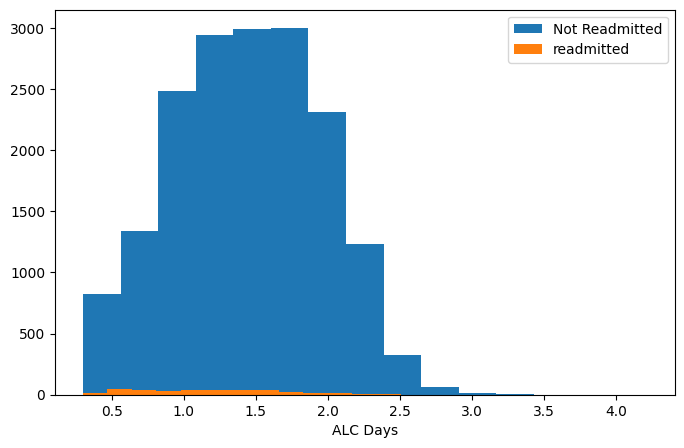

In [49]:

data = np.array([getattr(admission,'alc_days') for admission in all_admissions], )
y = health_data.Admission.get_y(all_admissions)
y = y[~np.isnan(data)]
data = data[~np.isnan(data)]

std_ = np.std(data)
print(f'Removed for ALC Days = {np.sum(data>np.mean(data)+3*std_)}')

data = np.log10(data+1)
y = y[data<=np.mean(data)+3*std_]
data = data[data<=np.mean(data)+3*std_]
fig, ax = plt.subplots(1,figsize=(8,5), )

y = y[data!=0]
data = data[data!=0]
ax.hist(data[y==0], bins=15, label='Not Readmitted')
ax.hist(data[y==1], bins=15, label='readmitted')
ax.legend()
ax.set_xlabel('ALC Days')

Removed for Acute Days = 394


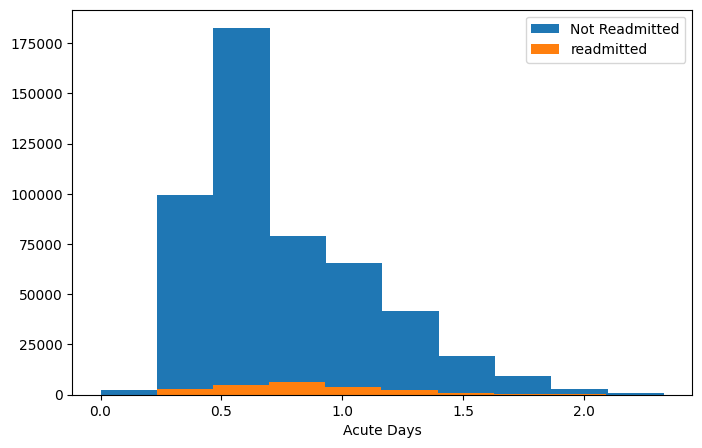

In [44]:
data = np.array([getattr(admission,'acute_days') for admission in all_admissions], )
y = health_data.Admission.get_y(all_admissions)


std_ = np.std(data)
print(f'Removed for Acute Days = {np.sum(data>np.mean(data)+3*std_)}')
y = y[data<=np.mean(data)+3*std_]
data = data[data<=np.mean(data)+3*std_]
fig, ax = plt.subplots(1,figsize=(8,5), )

data = np.log10(data+1)
ax.hist(data[y==0], bins=10, label='Not Readmitted')
ax.hist(data[y==1], bins=10, label='readmitted')
ax.set_xlabel('Acute Days')
ax.legend()

## Categoricals

  - institution_number
  - readmission_code
  - gender
  - mrdx
  - postal_code
  - admit_category
  - transfusion_given
  - main_pt_service
  - comorbidity_level
  - institution_to
  - institution_from
  - institution_type
  - discharge_unit
  - is_central_zone



In [104]:
categorical_fields = ['institution_number',
                      'mrdx',
                      'postal_code',
                      'main_pt_service',
                      'institution_to',
                      'institution_from',
                      'institution_type',
                      'discharge_unit',
                      'is_central_zone',
                      # Enums:
                      'readmission_code',
                      'gender',
                      'comorbidity_level',
                      'admit_category',
                      'transfusion_given',
                      ]
print('Variable;count;Levels;Mode;Mode Count;Less Frequent;Less Frequent Count;Missing Count')
for field in categorical_fields[:8]:
    data = [getattr(admission, field) for admission in all_admissions]
    total = len(data)
    data = [elem for elem in data if not elem is None]
    missing_count = total-len(data)
    levels = set(data)
    # Mode
    freq = defaultdict(int)
    for elem in data:
        freq[elem]+=1
    sorted_ = sorted(data, key=lambda elem:freq[elem])

    less_freq=sorted_[0]
    mode=sorted_[-1]
    
    print(f'{field};{len(data)};{len(levels)};{mode};count:{freq[mode]};{less_freq};count:{freq[less_freq]};{missing_count}')

for field in categorical_fields[8:]:
    data = [getattr(admission, field) for admission in all_admissions]
    total = len(data)
    data = [elem for elem in data if elem!=-1]
    missing_count = total-len(data)
    levels = set(data)
    # Mode
    freq = defaultdict(int)
    for elem in data:
        freq[elem]+=1
    sorted_ = sorted(data, key=lambda elem:freq[elem])

    less_freq=sorted_[0]
    mode=sorted_[-1]
    
    print(f'{field};{len(data)};{len(levels)};{mode};count:{freq[mode]};{less_freq};count:{freq[less_freq]};{missing_count}')


Variable;count;Levels;Mode;Mode Count;Less Frequent;Less Frequent Count;Missing Count
institution_number;524986;34;85;count:173024;58;count:42;0
mrdx;524986;6462;I214  Acute subendocardial myocardial infarction;count:16404;E8318  Other disorders of iron metabolism;count:1;0
postal_code;524986;32769;B0P1R0;count:5232;A2A7A1;count:1;0
main_pt_service;524890;52;General Medicine;count:115201;Paediatric Endocrinology;count:1;96
institution_to;154122;249;HOME CARE SERVICES-HOME CARE;count:19340;South Cumberland Hospital;count:1;370864
institution_from;165179;289;29087;count:15834;ST. MARTHA'S REGIONAL HOSPITAL-INPT REHAB;count:1;359807
institution_type;77847;28;OTHER (9002,9003,9088,9089);count:20602;NACRS AMBULATORY CARE (9);count:1;447139
discharge_unit;308048;153;D34;count:11894;10;count:1;216938
is_central_zone;524986;2;False;count:307037;True;count:217949;0
readmission_code;524986;7;ReadmissionCode.OTHER;count:212977;ReadmissionCode.NONE;count:458;0
gender;524986;5;Gender.FEMALE;count:2

### Plots

(array([1.0000e+00, 1.2486e+04, 3.4220e+03, 2.9660e+03, 1.8960e+03,
        1.0650e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3000e+02]),
 array([-1. , -0.1,  0.8,  1.7,  2.6,  3.5,  4.4,  5.3,  6.2,  7.1,  8. ]),
 <BarContainer object of 10 artists>)

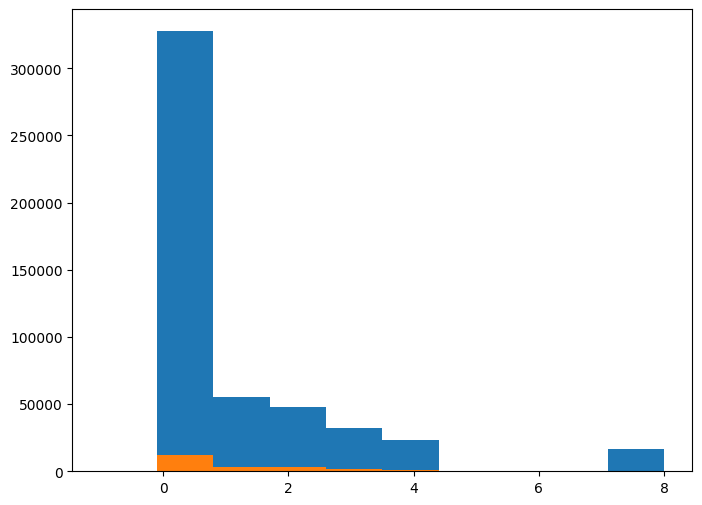

In [13]:
data = np.array([admission.comorbidity_level.value for admission in all_admissions])
y = health_data.Admission.get_y(all_admissions)

fig, ax = plt.subplots(1, figsize=(8,6))

ax.hist(data[y==0],)
ax.hist(data[y==1],)


In [7]:
all_admissions[0].gender.value

2

In [9]:
np.log10()

<module 'numpy' from '/Users/marianomaisonnave/Environments/alc/lib/python3.9/site-packages/numpy/__init__.py'>

In [16]:
(df['case_weight'].values)

array([1.3894, 0.6825, 1.8371, ..., 0.4942, 0.9858, 0.8879], dtype=object)

In [6]:
df = health_data.Admission.numerical_features(all_admissions,fix_skew=False)
df

,age,cmg,case_weight,acute_days,alc_days
0,67.0,285.0,1.3894,8.0,0.0
1,38.0,278.0,0.6825,2.0,0.0
2,62.0,319.0,1.8371,3.0,0.0
3,37.0,729.0,1.0085,1.0,0.0
4,49.0,321.0,1.4334,3.0,0.0
...,...,...,...,...,...
524981,74.0,780.0,0.5023,1.0,0.0
524982,61.0,234.0,0.4418,2.0,0.0
524983,73.0,778.0,0.4942,5.0,0.0
524984,68.0,386.0,0.9858,2.0,0.0


In [4]:
print(np.sum(df.isna()['age']))
print(np.sum(df.isna()['case_weight']))
print(np.sum(df.isna()['cmg']))
print(np.sum(df.isna()['acute_days']))
print(np.sum(df.isna()['alc_days']))

df.dropna()


NameError: name 'df' is not defined

NameError: name 'df' is not defined

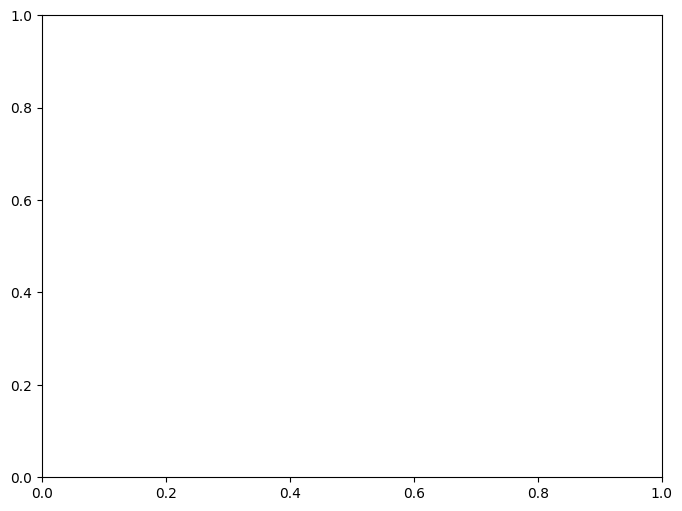

In [ ]:
fig,ax =plt.subplots(1, figsize=(8,6))
ax.hist(df['acute_days'])

In [17]:
df.shape

(524986, 5)